In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\sonso\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## The Problem
Several statistical inference procedures involve the comparison of two groups. We may be interested in whether one group is larger than another, or simply different from the other. We require a statistical model for this because true differences are usually accompanied by measurement or stochastic noise that prevent us from drawing conclusions simply from differences calculated from the observed data.

The de facto standard for statistically comparing two (or more) samples is to use a statistical test. This involves expressing a null hypothesis, which typically claims that there is no difference between the groups, and using a chosen test statistic to determine whether the distribution of the observed data is plausible under the hypothesis. This rejection occurs when the calculated test statistic is higher than some pre-specified threshold value.

Unfortunately, it is not easy to conduct hypothesis tests correctly, and their results are very easy to misinterpret. Setting up a statistical test involves several subjective choices (e.g. statistical test to use, null hypothesis to test, significance level) by the user that are rarely justified based on the problem or decision at hand, but rather, are usually based on traditional choices that are entirely arbitrary (Johnson 1999). The evidence that it provides to the user is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999).

A more informative and effective approach for comparing groups is one based on estimation rather than testing, and is driven by Bayesian probability rather than frequentist. That is, rather than testing whether two groups are different, we instead pursue an estimate of how different they are, which is fundamentally more informative. Moreover, we include an estimate of uncertainty associated with that difference which includes uncertainty due to our lack of knowledge of the model parameters (epistemic uncertainty) and uncertainty due to the inherent stochasticity of the system (aleatory uncertainty).

To illustrate how this Bayesian estimation approach works in practice, we will use a fictitious example from Kruschke (2012) concerning the evaluation of a clinical trial for drug evaluation. The trial aims to evaluate the efficacy of a “smart drug” that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment and control arms, respectively.

In [3]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

In [9]:
y1 = np.array(drug)
y2 = np.array(placebo)

# What does np.r_ do (numpy)?
# What it does is row-wise merging. https://stackoverflow.com/questions/30597869/what-does-np-r-do-numpy
y = pd.DataFrame(dict(value = np.r_[y1, y2], 
                      group = np.r_[["drug"] * len(drug), ["placebo"] * len(placebo)]))
y

,value,group
0,101,drug
1,100,drug
2,102,drug
3,104,drug
4,102,drug
...,...,...
84,100,placebo
85,102,placebo
86,99,placebo
87,100,placebo


The first step in a Bayesian approach to inference is to specify the full probability model that corresponds to the problem. For this example, Kruschke chooses a Student-t distribution to describe the distributions of the scores in each group. This choice adds robustness to the analysis, as a T distribution is less sensitive to outlier observations, relative to a normal distribution. The three-parameter Student-t distribution allows for the specification of a mean μ, a precision (inverse-variance) λ and a degrees-of-freedom parameter ν

$$f(x|\mu, \lambda, v) = \frac{\Gamma(\frac{v+1}{2})}{\Gamma(\frac{v}{2})} \Big(\frac{\lambda}{\pi v}\Big)^{\frac{1}{2}} \Big[ 1 + \frac{\lambda (x-\mu)^2}{v}\Big]^{-\frac{v+1}{2}}$$

the degrees-of-freedom parameter essentially specifies the “normality” of the data, since larger values of ν make the distribution converge to a normal distribution, while small values (close to zero) result in heavier tails.

The likelihood functions of our model are specified as follows:

$$y_i^{(treatment)} \sim T(v, \mu_1, \sigma_1)$$

$$y_i^{(placebo)} \sim T(v, \mu_2, \sigma_2)$$

As a simplifying assumption, we will assume that the degree of normality ν is the same for both groups. We will, of course, have separate parameters for the means $\mu_{k}$ ,k=1,2 and standard deviations $\sigma_{k}$.

Since the means are real-valued, we will apply normal priors on them, and arbitrarily set the hyperparameters to the pooled empirical mean of the data and twice the pooled empirical standard deviation, which applies very diffuse information to these quantities (and importantly, does not favor one or the other a priori).

$$\mu_k \sim N(\bar{x}, 2s)$$


The group standard deviations will be given a uniform prior over a plausible range of values for the variability of the outcome variable, IQ. We will set the group standard deviations to have a Uniform(1,10) prior. We follow Kruschke by making the prior for degree of freedom ν exponentially distributed with a mean of 30; this allocates high prior probability over the regions of the parameter that describe the range from normal to heavy-tailed data under the Student-T distribution.

Since PyMC3 parameterizes the Student-T in terms of precision, rather than standard deviation, we must transform the standard deviations before specifying our likelihoods. $\lambda = \frac{1}{\sigma^2}$

Having fully specified our probabilistic model, we can turn our attention to calculating the comparisons of interest in order to evaluate the effect of the drug. To this end, we can specify **deterministic nodes** in our model for the **difference between the group means and the difference between the group standard deviations**. Wrapping them in named Deterministic objects signals to PyMC that we wish to record the sampled values as part of the output.

As a joint measure of the groups, we will also estimate the “effect size”, which is the **difference in means scaled by the pooled estimates of standard deviation**. This quantity can be harder to interpret, since it is no longer in the same units as our data, but the quantity is a function of all four estimated parameters.

In [12]:
# Prior for group mean
mu_m = y.value.mean()
mu_s = y.value.std() * 2

# Prior for group standard deviation
sigma_low = 1
sigma_high = 10

# Set up prior for 2 groups
with pm.Model() as model:
    # Normal prior for group mean k = 1,2
    group1_mean = pm.Normal('group1_mean', mu = mu_m, sd = mu_s)
    group2_mean = pm.Normal('group2_mean', mu = mu_m, sd = mu_s)
    
    # Uniform prior for group standard deviation
    group1_std = pm.Uniform('group1_std', lower = sigma_low, upper = sigma_high)
    group2_std = pm.Uniform('group2_std', lower = sigma_low, upper = sigma_high)
    
    # Exponential prior for degree of freedom
    v = pm.Exponential('v_minus_one', 1/29) + 1
    
    # Transform the standard deviation to precision
    lambda_1 = group1_std ** -2
    lambda_2 = group2_std ** -2
    
    # Assign likelihood using T-distribution
    # You can see that we use the same prior for both drug and placebo population
    group1 = pm.StudentT("drug", nu = v, mu = group1_mean, lam = lambda_1, observed = y1)
    group2 = pm.StudentT("placebo", nu = v, mu = group2_mean, lam = lambda_2, observed = y2)
    
    # Deterministic nodes for difference of means and standard deviations between two groups
    diff_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
    diff_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic("effect size", diff_means / np.sqrt((group1_std ** 2 + group2_std **2) / 2))
    
    # Fit the model and evaluate the output as trace
    trace = pm.sample(2000, chains = 4, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 234 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E662CD3A0>,
      dtype=object)

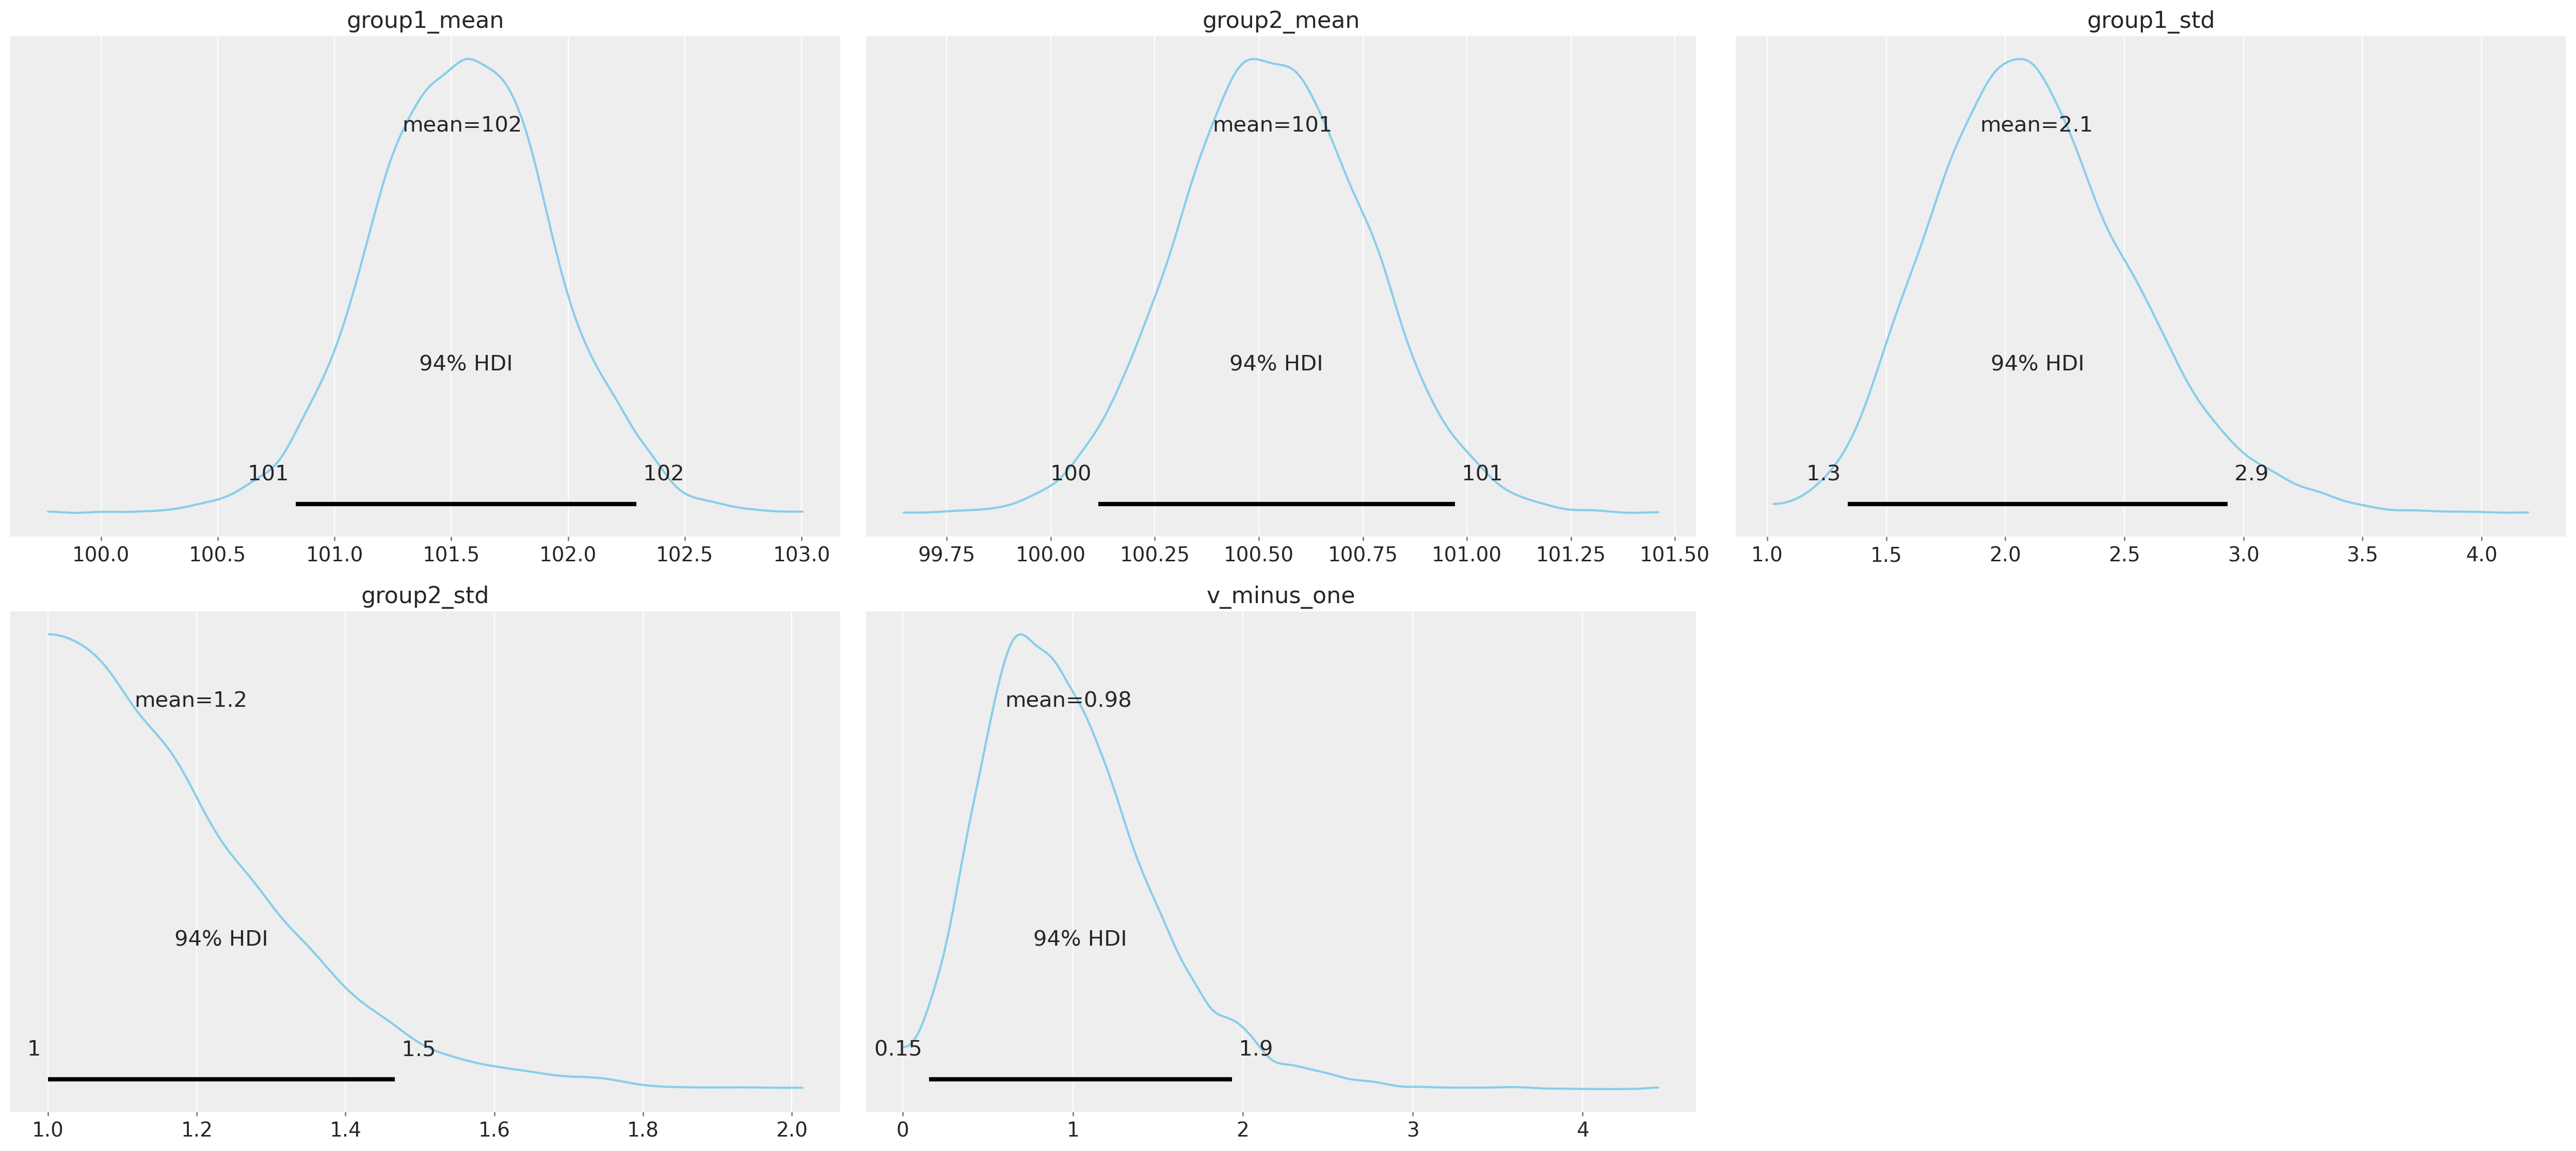

In [14]:
pm.plot_posterior(
    trace,
    var_names=["group1_mean", "group2_mean", "group1_std", "group2_std", "v_minus_one"],
    color="#87ceeb",
)

Looking at the group differences below, we can conclude that there are meaningful differences between the two groups for all three measures. For these comparisons, it is useful to use zero as a reference value (ref_val); providing this reference value yields cumulative probabilities for the posterior distribution on either side of the value. Thus, for the difference of means, at least 97% of the posterior probability are greater than zero, which suggests the group means are credibly different. The effect size and differences in standard deviation are similarly positive.

C:\Users\sonso\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E66B50F40>,
      dtype=object)

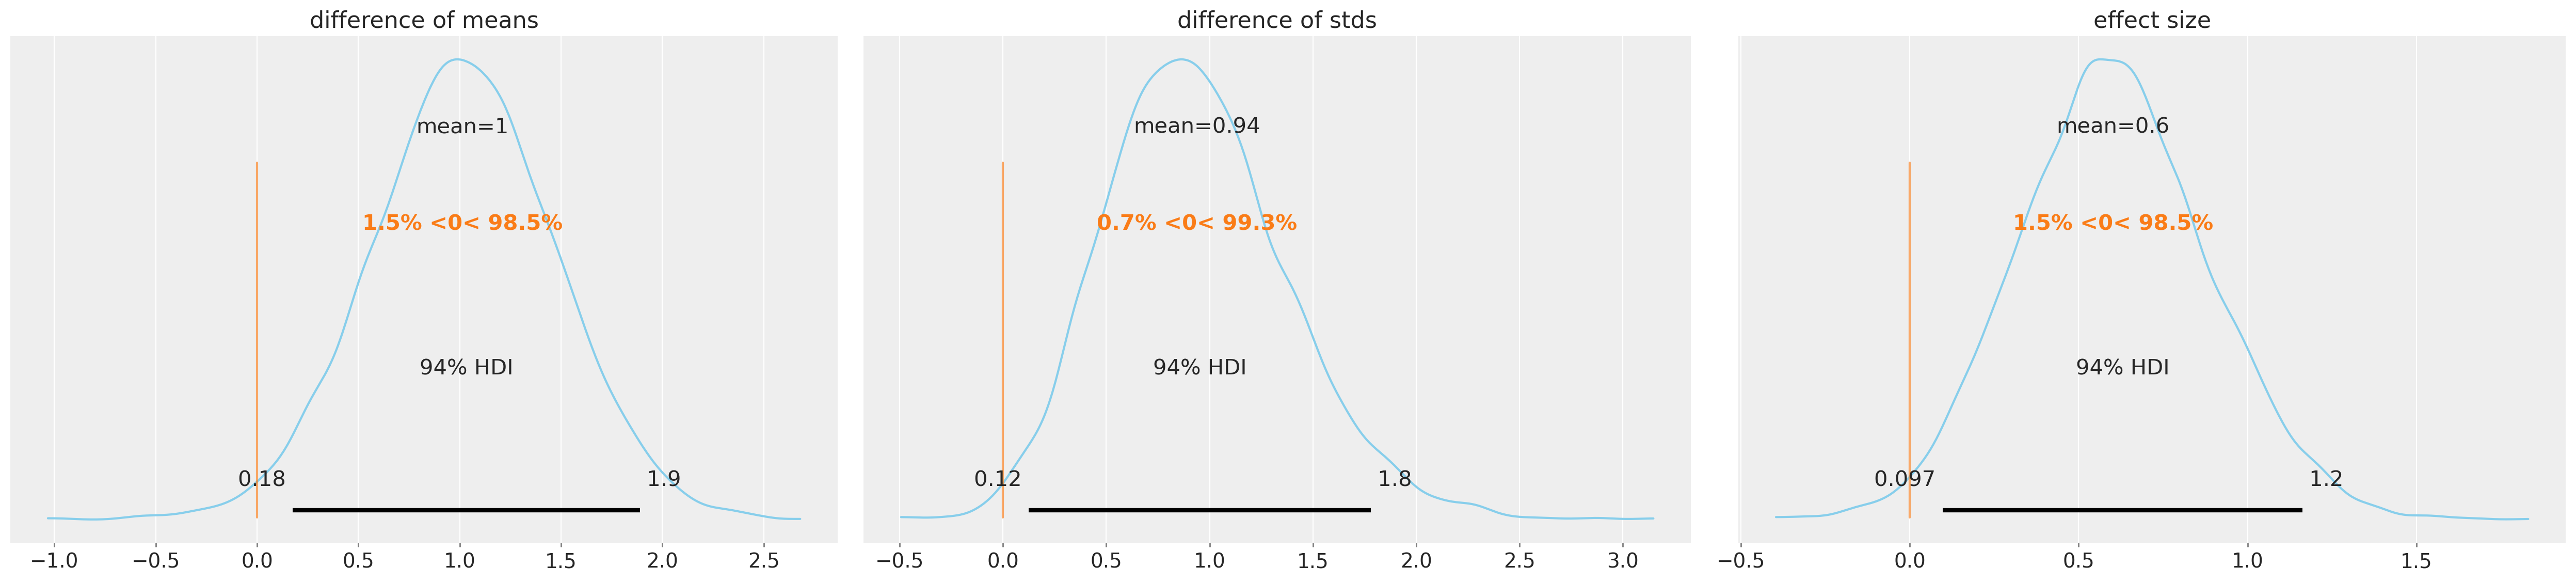

In [15]:
pm.plot_posterior(trace,
                  var_names = ["difference of means", "difference of stds", "effect size"],
                  ref_val = 0,
                  color = "#87ceeb")

When forestplot is called on a trace with more than one chain, it also plots the potential scale reduction parameter, which is used to reveal evidence for lack of convergence; values near one, as we have here, suggest that the model has converged.

C:\Users\sonso\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E66812220>],
      dtype=object)

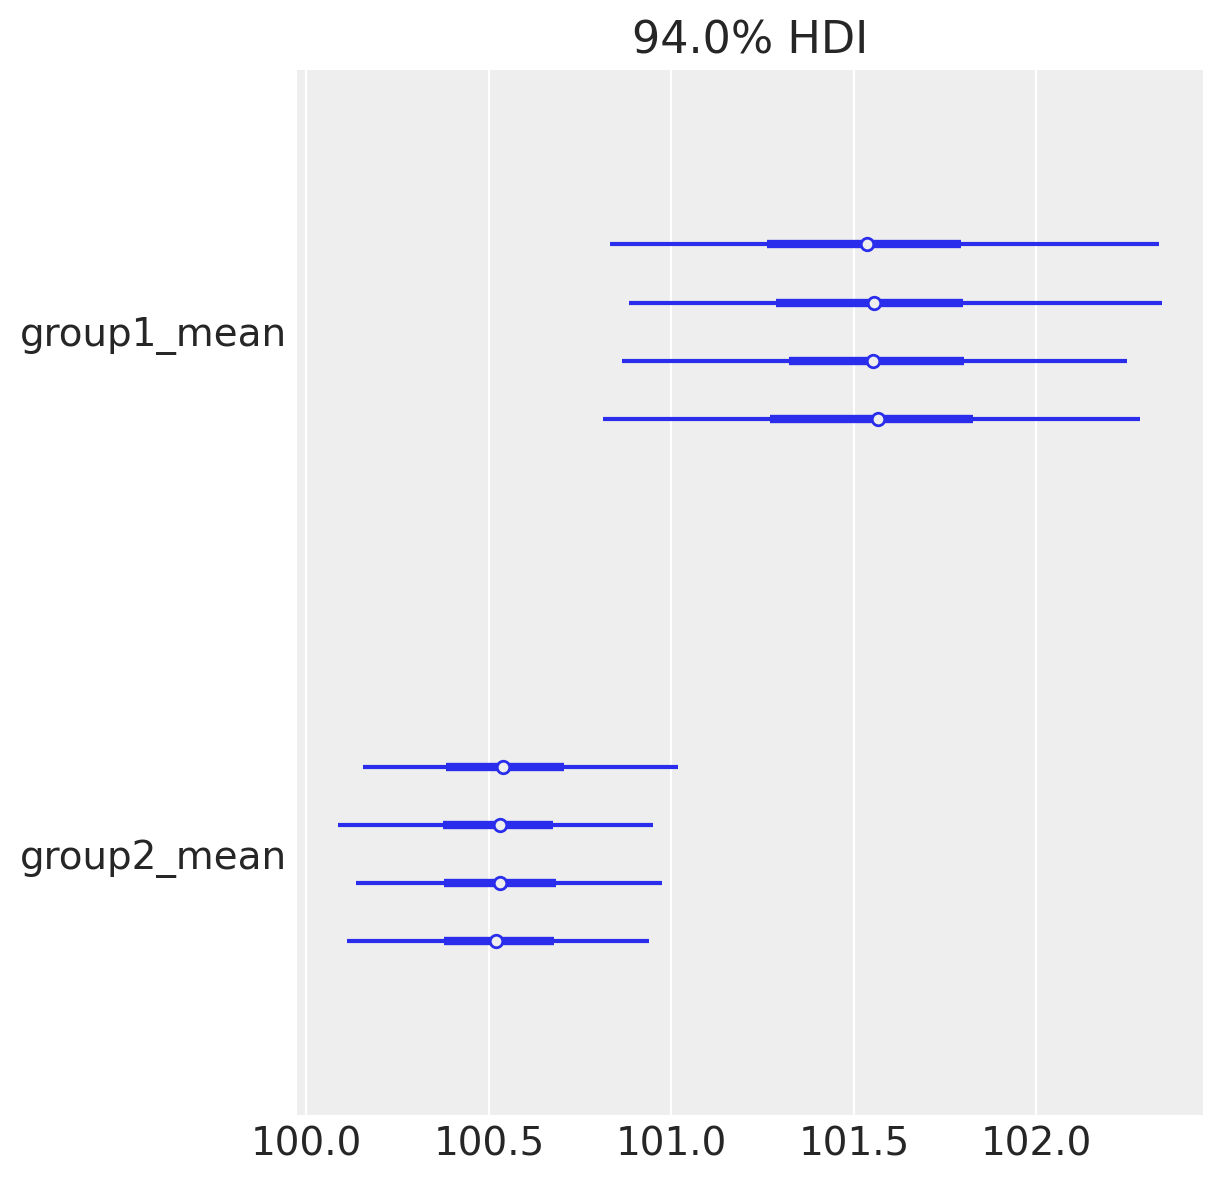

In [17]:
pm.forestplot(trace, 
          var_names = ["group1_mean", "group2_mean"])

In [ ]:
pm.forestplot(trace, 
          var_names = ["group1_std", "group2_std"])

In [18]:
pm.summary(trace, varnames = ["difference of means", "difference of stds", "effect size"])

C:\Users\sonso\Anaconda3\lib\site-packages\pymc3\stats\__init__.py:33: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
C:\Users\sonso\Anaconda3\lib\site-packages\arviz\data\io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
difference of means,1.014,0.459,0.176,1.890,0.006,0.004,5677.0,5658.0,5753.0,4903.0,1.0
difference of stds,0.938,0.444,0.124,1.782,0.006,0.004,5699.0,5699.0,5466.0,4693.0,1.0
effect size,0.601,0.285,0.097,1.163,0.004,0.003,5818.0,5818.0,5777.0,4628.0,1.0


In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Jan 08 2021

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

pymc3     : 3.9.3
arviz     : 0.10.0
numpy     : 1.18.5
pandas    : 1.0.5
matplotlib: 3.2.2

Watermark: 2.1.0

